In [ ]:
#Print the data structure

import pandas as pd
from pathlib import Path

data_dir = Path(".")
file_names = [
    "T_DB1B_TICKET.csv",
    "T_DB1B_MARKET.csv",
    "T_DB1B_COUPON.csv",
    "T_T100D_SEGMENT_ALL_CARRIER.csv"
]

for name in file_names:
    path = data_dir / name
    print("=" * 80)
    print(f"Loading file: {name}")
    
    try:
        df = pd.read_csv(path, nrows=5)  # read only a few rows
        print(f"✓ Loaded. Shape preview: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print("  -", col)
    except Exception as e:
        print(f"✗ Error reading {name}: {e}")


Loading file: T_DB1B_TICKET.csv
✓ Loaded. Shape preview: (5, 12)
Columns:
  - ITIN_ID
  - COUPONS
  - YEAR
  - QUARTER
  - ORIGIN
  - ROUNDTRIP
  - ONLINE
  - DOLLAR_CRED
  - PASSENGERS
  - ITIN_FARE
  - MILES_FLOWN
  - ITIN_GEO_TYPE
Loading file: T_DB1B_MARKET.csv
✓ Loaded. Shape preview: (5, 17)
Columns:
  - ITIN_ID
  - MKT_ID
  - MARKET_COUPONS
  - YEAR
  - QUARTER
  - ORIGIN
  - DEST
  - REPORTING_CARRIER
  - TICKET_CARRIER
  - OPERATING_CARRIER
  - PASSENGERS
  - MARKET_FARE
  - MARKET_DISTANCE
  - MARKET_MILES_FLOWN
  - NONSTOP_MILES
  - ITIN_GEO_TYPE
  - MKT_GEO_TYPE
Loading file: T_DB1B_COUPON.csv
✓ Loaded. Shape preview: (5, 16)
Columns:
  - ITIN_ID
  - MKT_ID
  - SEQ_NUM
  - COUPONS
  - YEAR
  - QUARTER
  - ORIGIN
  - DEST
  - TICKET_CARRIER
  - OPERATING_CARRIER
  - REPORTING_CARRIER
  - PASSENGERS
  - FARE_CLASS
  - DISTANCE
  - ITIN_GEO_TYPE
  - COUPON_GEO_TYPE
Loading file: T_T100D_SEGMENT_ALL_CARRIER.csv
✓ Loaded. Shape preview: (5, 10)
Columns:
  - SEATS
  - PASSENGERS


In [ ]:
# Merge 3 tables based on their unique ITIN_ID & MKT_ID

import pandas as pd


ticket = pd.read_csv("T_DB1B_TICKET.csv")
market = pd.read_csv("T_DB1B_MARKET.csv")
coupon = pd.read_csv("T_DB1B_COUPON.csv")
t100   = pd.read_csv("T_T100D_SEGMENT_ALL_CARRIER.csv")  # we will use this later

# Keep Direct = one coupon in the itinerary
ticket_direct = ticket[ticket["COUPONS"] == 1].copy()
market_direct = market[market["MARKET_COUPONS"] == 1].copy()
# keep the single segment (SEQ_NUM == 1) of those 1-coupon itineraries
coupon_direct = coupon[(coupon["COUPONS"] == 1) & (coupon["SEQ_NUM"] == 1)].copy()

# Merge Ticket + Market on ITIN_ID
db1b_tm = ticket_direct.merge(
    market_direct,
    on="ITIN_ID",
    how="inner",
    suffixes=("_TKT", "_MKT")
)

# From Coupon we only need fare class for cabin type
coupon_small = coupon_direct[["ITIN_ID", "MKT_ID", "FARE_CLASS"]].copy()

# Merge in FARE_CLASS using ITIN_ID + MKT_ID
db1b_master = db1b_tm.merge(
    coupon_small,
    on=["ITIN_ID", "MKT_ID"],
    how="left"
)

print("db1b_master shape:", db1b_master.shape)
print(db1b_master.head())


db1b_master shape: (817800, 29)
    ITIN_ID  COUPONS  YEAR_TKT  QUARTER_TKT ORIGIN_TKT  ROUNDTRIP  ONLINE  \
0  20241514        1      2024            1        EYW        0.0     1.0   
1  20241515        1      2024            1        EYW        0.0     1.0   
2  20241516        1      2024            1        EYW        0.0     1.0   
3  20241517        1      2024            1        EYW        0.0     1.0   
4  20241518        1      2024            1        EYW        0.0     1.0   

   DOLLAR_CRED  PASSENGERS_TKT  ITIN_FARE  ...  TICKET_CARRIER  \
0            1             1.0        0.0  ...              UA   
1            1             1.0       69.0  ...              3M   
2            1             2.0       77.0  ...              3M   
3            1             3.0       81.0  ...              UA   
4            1             6.0       89.0  ...              3M   

   OPERATING_CARRIER  PASSENGERS_MKT  MARKET_FARE  MARKET_DISTANCE  \
0                 3M             1.0  

In [9]:
df = db1b_master.copy()
before = len(df)
print("initial datapoint:", before)

initial datapoint: 817800


In [ ]:
# Keep credible fares (DollarCred=1)

df = df[df["DOLLAR_CRED"] == 1]
_stepA = len(df)
print("Credible fares left:", _stepA)

Credible fares left: 808779


In [ ]:
# Drop first/business class using FARE_CLASS

def is_coach(fc):
    if pd.isna(fc):
        return False
    c = str(fc).strip().upper()
    if c.startswith(("F", "G", "A", "C", "J", "D", "I")):
        return False
    return True

df = df[df["FARE_CLASS"].apply(is_coach)]
_stepB = len(df)
print("Coach-class left:", _stepB)

Coach-class left: 767523


In [ ]:
# Remove frequent flyer / zero fares / tiny fares

df["ROUNDTRIP"] = df["ROUNDTRIP"].astype(float)

ff_mask = (
    (df["ITIN_FARE"] == 0) |
    ((df["ROUNDTRIP"] == 1) & (df["ITIN_FARE"] <= 20)) |
    ((df["ROUNDTRIP"] != 1) & (df["ITIN_FARE"] <= 10))
)

df = df[~ff_mask]
_stepC = len(df)
print("After removing FF/zero/tiny fares:", _stepC)

After removing FF/zero/tiny fares: 752792


In [ ]:
# Remove codeshares

df = df[df["TICKET_CARRIER"] == df["OPERATING_CARRIER"]]
_stepD = len(df)
print("After removing codeshares:", _stepD)


After removing codeshares: 633970


In [18]:
# Make a copy
db1b_clean = df.copy()

# Standardize YEAR + QUARTER
if "YEAR_TKT" in db1b_clean.columns:
    db1b_clean["YEAR"] = db1b_clean["YEAR_TKT"]
if "QUARTER_TKT" in db1b_clean.columns:
    db1b_clean["QUARTER"] = db1b_clean["QUARTER_TKT"]

# Standardize ORIGIN + DEST
origin_candidates = ["ORIGIN", "ORIGIN_TKT", "ORIGIN_MKT"]
dest_candidates   = ["DEST", "DEST_TKT", "DEST_MKT"]

for c in origin_candidates:
    if c in db1b_clean.columns:
        db1b_clean["ORIGIN_ROUTE"] = db1b_clean[c]
        break

for c in dest_candidates:
    if c in db1b_clean.columns:
        db1b_clean["DEST_ROUTE"] = db1b_clean[c]
        break

# Standardize carrier
db1b_clean["CARRIER"] = db1b_clean["OPERATING_CARRIER"]

# Standardize fare variable
db1b_clean["FARE"] = db1b_clean["MARKET_FARE"]

# Print summary
print("FINAL DB1B CLEAN SHAPE:", db1b_clean.shape)
print("Origin column example:", db1b_clean["ORIGIN_ROUTE"].iloc[0])
print("Dest column example:", db1b_clean["DEST_ROUTE"].iloc[0])
db1b_clean.head()


FINAL DB1B CLEAN SHAPE: (633970, 35)
Origin column example: EYW
Dest column example: FLL


,ITIN_ID,COUPONS,YEAR_TKT,QUARTER_TKT,ORIGIN_TKT,ROUNDTRIP,ONLINE,DOLLAR_CRED,PASSENGERS_TKT,ITIN_FARE,...,NONSTOP_MILES,ITIN_GEO_TYPE_MKT,MKT_GEO_TYPE,FARE_CLASS,CARRIER,YEAR,QUARTER,ORIGIN_ROUTE,DEST_ROUTE,FARE
1,20241515,1,2024,1,EYW,0.0,1.0,1,1.0,69.0,...,145.0,2,2,Y,3M,2024,1,EYW,FLL,69.0
2,20241516,1,2024,1,EYW,0.0,1.0,1,2.0,77.0,...,145.0,2,2,X,3M,2024,1,EYW,FLL,77.0
4,20241518,1,2024,1,EYW,0.0,1.0,1,6.0,89.0,...,145.0,2,2,X,3M,2024,1,EYW,FLL,89.0
6,20241520,1,2024,1,EYW,0.0,1.0,1,1.0,99.0,...,145.0,2,2,X,3M,2024,1,EYW,FLL,99.0
7,20241521,1,2024,1,EYW,0.0,1.0,1,4.0,100.0,...,145.0,2,2,X,3M,2024,1,EYW,FLL,100.0


In [22]:
import numpy as np
import pandas as pd


def gini_unweighted(x):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.nan
    if np.all(x == 0):
        return 0.0
    x = np.sort(x)
    n = x.size
    i = np.arange(1, n + 1)
    return (2 * (i * x).sum() / (n * x.sum())) - (n + 1) / n

db1b_clean["fare_per_mile"] = db1b_clean["FARE"] / db1b_clean["NONSTOP_MILES"]

group_cols = ["YEAR", "QUARTER", "CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE"]

db1b_route = (
    db1b_clean
    .groupby(group_cols)
    .agg(
        n_tickets=("ITIN_ID", "count"),
        passengers_db1b=("PASSENGERS_TKT", "sum"),
        avg_fare=("FARE", "mean"),
        avg_fare_per_mile=("fare_per_mile", "mean"),
        gini=("FARE", gini_unweighted),
        gini_per_mile=("fare_per_mile", gini_unweighted),
        nonstop_miles=("NONSTOP_MILES", "first")
    )
    .reset_index()
)

print("db1b_route shape:", db1b_route.shape)
db1b_route.head()


db1b_route shape: (9323, 12)


,YEAR,QUARTER,CARRIER,ORIGIN_ROUTE,DEST_ROUTE,n_tickets,passengers_db1b,avg_fare,avg_fare_per_mile,gini,gini_per_mile,nonstop_miles
0,2024,1,3M,EYW,FLL,19,53.0,134.473684,0.927405,0.185601,0.185601,145.0
1,2024,1,3M,EYW,MCO,38,133.0,162.210526,0.605263,0.200084,0.200084,268.0
2,2024,1,3M,EYW,TPA,38,104.0,197.526316,0.823026,0.209811,0.209811,240.0
3,2024,1,3M,FLL,EYW,16,35.0,145.187500,1.001293,0.177814,0.177814,145.0
4,2024,1,3M,FLL,GNV,30,89.0,157.033333,0.558837,0.253117,0.253117,281.0


In [39]:
import numpy as np
import pandas as pd

df_g = db1b_route.copy()

#  clean invalid values
df_g = df_g.replace([np.inf, -np.inf], np.nan).dropna(subset=["gini"])

# keep only meaningful observations: at least 100 tickets
df_g = df_g[df_g["n_tickets"] >= 200]   


#  Top 10 highest Gini
top10 = df_g.sort_values("gini", ascending=False).head(10)

#  Bottom 10 lowest Gini
bottom10 = df_g.sort_values("gini", ascending=True).head(10)

print("=== Highest Gini (Top 10 carrier–routes) ===")
print(top10[["CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE", "n_tickets",
             "gini", "avg_fare"]])

print("\n=== Lowest Gini (Bottom 10 carrier–routes) ===")
print(bottom10[["CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE", "n_tickets",
               "gini", "avg_fare"]])


=== Highest Gini (Top 10 carrier–routes) ===
     CARRIER ORIGIN_ROUTE DEST_ROUTE  n_tickets      gini    avg_fare
6030      UA          SFO        KOA        203  0.434131  443.147783
5556      UA          LAX        HNL        354  0.424245  444.776836
5641      UA          MIA        SFO        329  0.421801  486.392097
6037      UA          SFO        MIA        286  0.418333  433.863636
4064      HA          HNL        LAX        298  0.417071  400.208054
5522      UA          KOA        LAX        221  0.416890  540.194570
2208      DL          LAX        MCO        337  0.414015  459.344214
2102      DL          HNL        LAX        236  0.413787  496.300847
5082      UA          BOS        SFO        431  0.409544  538.744780
5524      UA          KOA        SFO        215  0.402668  442.967442

=== Lowest Gini (Bottom 10 carrier–routes) ===
     CARRIER ORIGIN_ROUTE DEST_ROUTE  n_tickets      gini    avg_fare
8629      WN          SAN        PHX        203  0.245511  194.7586

Regression: gini = -0.000014 * nonstop_miles + 0.267796


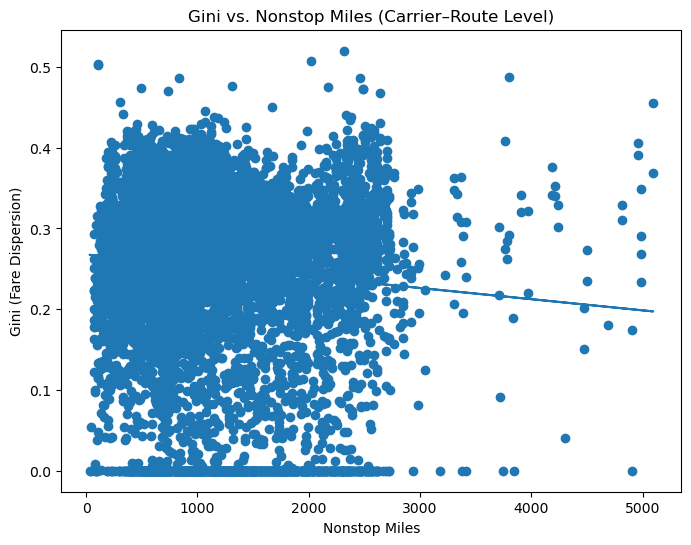

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# prepare data
df_plot = db1b_route.copy()
df_plot = df_plot.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot.dropna(subset=["gini", "nonstop_miles"])

X = df_plot["nonstop_miles"].values
y = df_plot["gini"].values

# simple OLS (numpy)
coef = np.polyfit(X, y, 1)
line = coef[0] * X + coef[1]

print("Regression: gini = {:.6f} * nonstop_miles + {:.6f}".format(coef[0], coef[1]))

# plotting
plt.figure(figsize=(8,6))
plt.scatter(X, y)
plt.plot(X, line)
plt.xlabel("Nonstop Miles")
plt.ylabel("Gini (Fare Dispersion)")
plt.title("Gini vs. Nonstop Miles (Carrier–Route Level)")
plt.show()


## T100 Table 

In [23]:
t = t100.copy()

keep_cols = [
    "YEAR", "QUARTER", "MONTH",
    "CARRIER",
    "ORIGIN", "DEST",
    "PASSENGERS", "DISTANCE"
]

t = t[keep_cols].copy()

# Keep passenger-carrying segments
t = t[t["PASSENGERS"] > 0].copy()

print("T100 cleaned shape:", t.shape)
t.head()


T100 cleaned shape: (366919, 8)


,YEAR,QUARTER,MONTH,CARRIER,ORIGIN,DEST,PASSENGERS,DISTANCE
45128,2024,2,4,8C,LAX,RNO,9.0,391.0
45537,2024,2,5,7S,RSH,RSH,1.0,0.0
45538,2024,2,6,7S,RSH,RSH,1.0,0.0
45539,2024,2,6,7S,SLQ,RDV,1.0,9.0
45540,2024,3,7,7S,CHU,ANI,1.0,11.0


In [24]:
# Group by carrier–route–quarter
group_cols_t = ["YEAR", "QUARTER", "CARRIER", "ORIGIN", "DEST"]

t100_carrier_route = (
    t
    .groupby(group_cols_t)
    .agg(
        passengers_t100=("PASSENGERS", "sum"),
        distance_t100=("DISTANCE", "mean")
    )
    .reset_index()
)

print("t100_carrier_route shape:", t100_carrier_route.shape)
t100_carrier_route.head()


t100_carrier_route shape: (92963, 7)


,YEAR,QUARTER,CARRIER,ORIGIN,DEST,passengers_t100,distance_t100
0,2024,1,02Q,AUS,MIA,1.0,1103.0
1,2024,1,02Q,KOA,GUM,44.0,3928.0
2,2024,1,04Q,2GA,RSW,3.0,355.0
3,2024,1,04Q,2GA,SUA,3.0,369.0
4,2024,1,04Q,3FL,TMB,4.0,157.0


In [25]:
route_keys = ["YEAR", "QUARTER", "ORIGIN", "DEST"]

# total passenger count on each ROUTE (sum across carriers)
t100_carrier_route["route_total_passengers"] = (
    t100_carrier_route
    .groupby(route_keys)["passengers_t100"]
    .transform("sum")
)

# carrier's market share
t100_carrier_route["share"] = (
    t100_carrier_route["passengers_t100"] /
    t100_carrier_route["route_total_passengers"]
)

t100_carrier_route.head()


,YEAR,QUARTER,CARRIER,ORIGIN,DEST,passengers_t100,distance_t100,route_total_passengers,share
0,2024,1,02Q,AUS,MIA,1.0,1103.0,62375.0,0.000016
1,2024,1,02Q,KOA,GUM,44.0,3928.0,44.0,1.000000
2,2024,1,04Q,2GA,RSW,3.0,355.0,3.0,1.000000
3,2024,1,04Q,2GA,SUA,3.0,369.0,3.0,1.000000
4,2024,1,04Q,3FL,TMB,4.0,157.0,4.0,1.000000


In [26]:
t100_carrier_route["HHI"] = (
    t100_carrier_route
    .groupby(route_keys)["share"]
    .transform(lambda s: (s ** 2).sum())
)

print("Sample HHI rows:")
t100_carrier_route.head()


Sample HHI rows:


,YEAR,QUARTER,CARRIER,ORIGIN,DEST,passengers_t100,distance_t100,route_total_passengers,share,HHI
0,2024,1,02Q,AUS,MIA,1.0,1103.0,62375.0,0.000016,0.565555
1,2024,1,02Q,KOA,GUM,44.0,3928.0,44.0,1.000000,1.000000
2,2024,1,04Q,2GA,RSW,3.0,355.0,3.0,1.000000,1.000000
3,2024,1,04Q,2GA,SUA,3.0,369.0,3.0,1.000000,1.000000
4,2024,1,04Q,3FL,TMB,4.0,157.0,4.0,1.000000,1.000000


In [41]:
merge_cols = ["YEAR", "QUARTER", "CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE"]

# prepare T100 for merge (rename ORIGIN/DEST to match db1b_route)
t100_merge_ready = t100_carrier_route.rename(
    columns={
        "ORIGIN": "ORIGIN_ROUTE",
        "DEST": "DEST_ROUTE"
    }
)

db1b_panel = db1b_route.merge(
    t100_merge_ready[
        ["YEAR","QUARTER","CARRIER","ORIGIN_ROUTE","DEST_ROUTE",
         "passengers_t100","route_total_passengers","share","HHI",
         "distance_t100"]
    ],
    on=merge_cols,
    how="inner"
)

print("Final merged dataset shape:", db1b_panel.shape)
db1b_panel.head()


Final merged dataset shape: (7633, 17)


,YEAR,QUARTER,CARRIER,ORIGIN_ROUTE,DEST_ROUTE,n_tickets,passengers_db1b,avg_fare,avg_fare_per_mile,gini,gini_per_mile,nonstop_miles,passengers_t100,route_total_passengers,share,HHI,distance_t100
0,2024,1,3M,EYW,FLL,19,53.0,134.473684,0.927405,0.185601,0.185601,145.0,2432.0,2737.0,0.888564,0.800951,145.0
1,2024,1,3M,EYW,MCO,38,133.0,162.210526,0.605263,0.200084,0.200084,268.0,4925.0,5184.0,0.950039,0.905069,268.0
2,2024,1,3M,EYW,TPA,38,104.0,197.526316,0.823026,0.209811,0.209811,240.0,6549.0,7026.0,0.932109,0.873437,240.0
3,2024,1,3M,FLL,EYW,16,35.0,145.187500,1.001293,0.177814,0.177814,145.0,1999.0,2144.0,0.932369,0.872989,145.0
4,2024,1,3M,FLL,GNV,30,89.0,157.033333,0.558837,0.253117,0.253117,281.0,1992.0,1992.0,1.000000,1.000000,281.0


In [42]:
import statsmodels.formula.api as smf

reg = smf.ols(
    "gini ~ HHI + np.log(nonstop_miles)",
    data=db1b_panel
).fit()

print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     247.5
Date:                Mon, 17 Nov 2025   Prob (F-statistic):          6.97e-105
Time:                        11:37:07   Log-Likelihood:                 10004.
No. Observations:                7633   AIC:                        -2.000e+04
Df Residuals:                    7630   BIC:                        -1.998e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.20

In [ ]:
import numpy as np
import pandas as pd

df = db1b_panel.copy() 
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["HHI", "gini"])


df = df[df["n_tickets"] >= 200]

print("Remaining observations after filter:", df.shape)

# 1. Top 10 most competitive routes (lowest HHI)
most_competitive = (
    df.sort_values("HHI", ascending=True)
      .head(10)
      .copy()
)


# 2. Top 10 most concentrated routes (highest HHI)
most_concentrated = (
    df.sort_values("HHI", ascending=False)
      .head(10)
      .copy()
)

print("\n=== Top 10 MOST COMPETITIVE routes (lowest HHI) ===")
print(most_competitive[
    ["CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE",
     "HHI", "share", "avg_fare", "avg_fare_per_mile",
     "gini", "n_tickets"]
])

print("\n=== Top 10 MOST CONCENTRATED routes (highest HHI) ===")
print(most_concentrated[
    ["CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE",
     "HHI", "share", "avg_fare", "avg_fare_per_mile",
     "gini", "n_tickets"]
])

#  Compare average Gini across the two sets
gini_comp = pd.DataFrame({
    "Group": ["Most Competitive (Low HHI)", "Most Concentrated (High HHI)"],
    "Mean Gini": [
        most_competitive["gini"].mean(),
        most_concentrated["gini"].mean()
    ],
    "Median Gini": [
        most_competitive["gini"].median(),
        most_concentrated["gini"].median()
    ]
})

print("\n=== Price Dispersion Comparison (Gini) ===")
print(gini_comp)


Remaining observations after filter: (514, 17)

=== Top 10 MOST COMPETITIVE routes (lowest HHI) ===
     CARRIER ORIGIN_ROUTE DEST_ROUTE       HHI     share    avg_fare  \
5358      UA          LAS        LAX  0.183205  0.145624  208.942652   
2106      DL          LAS        LAX  0.183205  0.176124  223.224215   
6533      WN          LAS        LAX  0.183205  0.293192  161.911565   
2133      DL          LAX        LAS  0.184035  0.177136  219.964286   
5374      UA          LAX        LAS  0.184035  0.150636  192.362903   
6583      WN          LAX        LAS  0.184035  0.293060  160.291096   
2128      DL          LAX        HNL  0.203657  0.200201  425.080292   
5370      UA          LAX        HNL  0.203657  0.244929  444.776836   
3972      HA          LAX        HNL  0.203657  0.248344  334.199234   
2031      DL          HNL        LAX  0.206452  0.204712  496.300847   

      avg_fare_per_mile      gini  n_tickets  
5358           0.885350  0.323020        279  
2106         